# Data Loading + Cleaning + Merging

In [2]:
# import packages
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, Circle
import matplotlib as mpl

import warnings
warnings.filterwarnings('ignore')

In [3]:
# load main dataset
df = pd.read_csv("beam_dashboard.csv")

In [4]:
# preview dataset
df.head()

,Year,Month,State,Source,Pathogen,Serotype/Species,Number of isolates,Outbreak associated isolates,New multistate outbreaks,New multistate outbreaks - US,% Isolates with clinically important antimicrobial resistance,Number of sequenced isolates analyzed by NARMS
0,2024,1,AK,Stool,Campylobacter,jejuni,1,NaN,NaN,NaN,NaN,NaN
1,2024,1,AL,Stool,Campylobacter,coli,1,NaN,NaN,NaN,NaN,NaN
2,2024,1,AL,Stool,Campylobacter,jejuni,2,NaN,NaN,NaN,NaN,NaN
3,2024,1,AR,Stool,Campylobacter,jejuni,1,NaN,NaN,NaN,NaN,NaN
4,2024,1,CA,Stool,Campylobacter,jejuni,1,NaN,NaN,NaN,NaN,NaN


In [5]:
# drop columns to the right of 'Number of isolates' due to tons of missing / N/A data
df = df.drop(['Outbreak associated isolates', 
              'New multistate outbreaks', 
              'New multistate outbreaks - US', 
              '% Isolates with clinically important antimicrobial resistance',
              'Number of sequenced isolates analyzed by NARMS'], axis = 1)
df.head()

,Year,Month,State,Source,Pathogen,Serotype/Species,Number of isolates
0,2024,1,AK,Stool,Campylobacter,jejuni,1
1,2024,1,AL,Stool,Campylobacter,coli,1
2,2024,1,AL,Stool,Campylobacter,jejuni,2
3,2024,1,AR,Stool,Campylobacter,jejuni,1
4,2024,1,CA,Stool,Campylobacter,jejuni,1


In [6]:
# rename columns
df.columns = ['year', 'month', 'state', 'source', 'pathogen', 'serotype_species', 'num_isolates']
df.head()

,year,month,state,source,pathogen,serotype_species,num_isolates
0,2024,1,AK,Stool,Campylobacter,jejuni,1
1,2024,1,AL,Stool,Campylobacter,coli,1
2,2024,1,AL,Stool,Campylobacter,jejuni,2
3,2024,1,AR,Stool,Campylobacter,jejuni,1
4,2024,1,CA,Stool,Campylobacter,jejuni,1


In [7]:
# check for missing values
df.isna().sum()

year                0
month               0
state               5
source              0
pathogen            0
serotype_species    0
num_isolates        0
dtype: int64

In [8]:
# drop rows where state information is not available, messes up geospatial data later on
df = df.dropna()
# verify that there is no more missing data
df.isna().sum()

year                0
month               0
state               0
source              0
pathogen            0
serotype_species    0
num_isolates        0
dtype: int64

In [9]:
df['source'].unique()

array(['Stool', 'Blood', 'Other', 'Urine'], dtype=object)

In [10]:
shapefile_path = ("tl_2024_us_state/tl_2024_us_state.shp")
gdf = gpd.read_file(shapefile_path)

In [11]:
# tutorial for mapping from Oscar Leo in DEV

# define features
edge_color = "#0d0c0d"

sns.set_style({
    "font.family": "DejaVu Sans"
})

In [12]:
# remove “unincorporated territories” such as Guam, Puerto Rico, and American Samoa
states = gdf[~gdf.STATEFP.isin(["72", "69", "60", "66", "78"])]

# adjust the state mapping projection
states = states.to_crs("ESRI:102003")

In [13]:
# translating data to draw Alaska and Hawaii under mainland USA (just for aesthetic purposes!)
def translate_geometries(df, x, y, scale, rotate):
    df.loc[:, "geometry"] = df.geometry.translate(yoff = y, xoff = x)
    center = df.dissolve().centroid.iloc[0]
    df.loc[:, "geometry"] = df.geometry.scale(xfact = scale, yfact = scale, origin = center)
    df.loc[:, "geometry"] = df.geometry.rotate(rotate, origin = center)
    return df

In [14]:
# separates Hawaii and Alaska to adjust their geometries
def adjust_maps(df):
    df_main_land = df[~df.STATEFP.isin(["02", "15"])]
    df_alaska = df[df.STATEFP == "02"]
    df_hawaii = df[df.STATEFP == "15"]
    
    # putting them back into new dataframes
    df_alaska = translate_geometries(df_alaska, 1300000, -4900000, 0.5, 32)
    df_hawaii = translate_geometries(df_hawaii, 5400000, -1500000, 1, 24)

    return pd.concat([df_main_land, df_alaska, df_hawaii])

In [15]:
# adding adjust_maps to the code
states = adjust_maps(states)

In [16]:
# merging shapefiles to the data
merged_df = df.merge(states, left_on='state', right_on='STUSPS')

In [17]:
merged_df.head()

,year,month,state,source,pathogen,serotype_species,num_isolates,REGION,DIVISION,STATEFP,...,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,2024,1,AK,Stool,Campylobacter,jejuni,1,4,9,02,...,AK,Alaska,00,G4000,A,1479508971743,244710526650,+63.3473560,-152.8397334,"MULTIPOLYGON (((-2778499.467 -1620603.792, -27..."
1,2024,1,AL,Stool,Campylobacter,coli,1,3,6,01,...,AL,Alabama,00,G4000,A,131185561946,4581813708,+32.7395785,-086.8434469,"POLYGON ((1023282.917 -582853.454, 1023269.168..."
2,2024,1,AL,Stool,Campylobacter,jejuni,2,3,6,01,...,AL,Alabama,00,G4000,A,131185561946,4581813708,+32.7395785,-086.8434469,"POLYGON ((1023282.917 -582853.454, 1023269.168..."
3,2024,1,AR,Stool,Campylobacter,jejuni,1,3,7,05,...,AR,Arkansas,00,G4000,A,134658517854,3122715710,+34.8955256,-092.4446262,"POLYGON ((461603.731 -366288.124, 461727.959 -..."
4,2024,1,CA,Stool,Campylobacter,jejuni,1,4,9,06,...,CA,California,00,G4000,A,403673433805,20291632828,+37.1551773,-119.5434183,"MULTIPOLYGON (((-1976277.366 663684.581, -1976..."


In [18]:
merged_df.columns

Index(['year', 'month', 'state', 'source', 'pathogen', 'serotype_species',
       'num_isolates', 'REGION', 'DIVISION', 'STATEFP', 'STATENS', 'GEOID',
       'GEOIDFQ', 'STUSPS', 'NAME', 'LSAD', 'MTFCC', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry'],
      dtype='object')

In [19]:
# keeping certain columns for EDA
merged_df = merged_df[['year', 'month', 'state', 'source', 'pathogen', 'serotype_species', 'num_isolates', 'geometry']]
merged_df.head()

,year,month,state,source,pathogen,serotype_species,num_isolates,geometry
0,2024,1,AK,Stool,Campylobacter,jejuni,1,"MULTIPOLYGON (((-2778499.467 -1620603.792, -27..."
1,2024,1,AL,Stool,Campylobacter,coli,1,"POLYGON ((1023282.917 -582853.454, 1023269.168..."
2,2024,1,AL,Stool,Campylobacter,jejuni,2,"POLYGON ((1023282.917 -582853.454, 1023269.168..."
3,2024,1,AR,Stool,Campylobacter,jejuni,1,"POLYGON ((461603.731 -366288.124, 461727.959 -..."
4,2024,1,CA,Stool,Campylobacter,jejuni,1,"MULTIPOLYGON (((-1976277.366 663684.581, -1976..."


# EDA

### Analyzing the number of cases per year

In [20]:
counts_per_year = merged_df.groupby(['year', 'pathogen']).size().unstack(fill_value=0)
counts_per_year['Total'] = counts_per_year['Campylobacter'] + counts_per_year['STEC'] + counts_per_year['Salmonella'] + counts_per_year['Shigella'] + counts_per_year['Vibrio']
counts_per_year.head()

pathogen,Campylobacter,STEC,Salmonella,Shigella,Vibrio,Total
year,,,,,,
2018,737,0,18114,0,137,18988
2019,650,0,17634,0,175,18459
2020,473,0,15037,0,130,15640
2021,481,0,16215,0,168,16864
2022,553,0,15810,0,256,16619


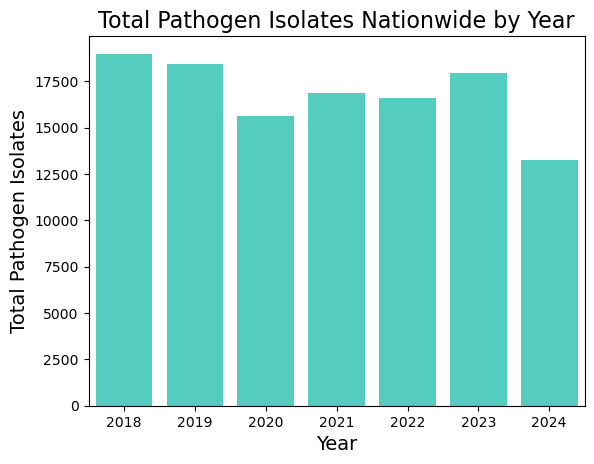

In [21]:
# visualizing total pathogen isolates nationwide by year
sns.barplot(x='year', y='Total', data=counts_per_year, color='turquoise')
plt.title('Total Pathogen Isolates Nationwide by Year', fontsize = 16)
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Total Pathogen Isolates', fontsize = 14)
plt.show()

### Analyzing the number of cases per pathogen type per month

In [22]:
# create a dataframe counts_per_month
counts_per_month = merged_df.groupby(['month', 'pathogen']).size().unstack(fill_value=0)
counts_per_month['Total'] = counts_per_month['Campylobacter'] + counts_per_month['STEC'] + counts_per_month['Salmonella'] + counts_per_month['Shigella'] + counts_per_month['Vibrio']
counts_per_month.head()

pathogen,Campylobacter,STEC,Salmonella,Shigella,Vibrio,Total
month,,,,,,
1,335,0,8108,0,43,8486
2,310,0,6880,0,36,7226
3,321,0,7680,2,53,8056
4,333,1,8395,2,50,8781
5,369,0,9861,2,90,10322


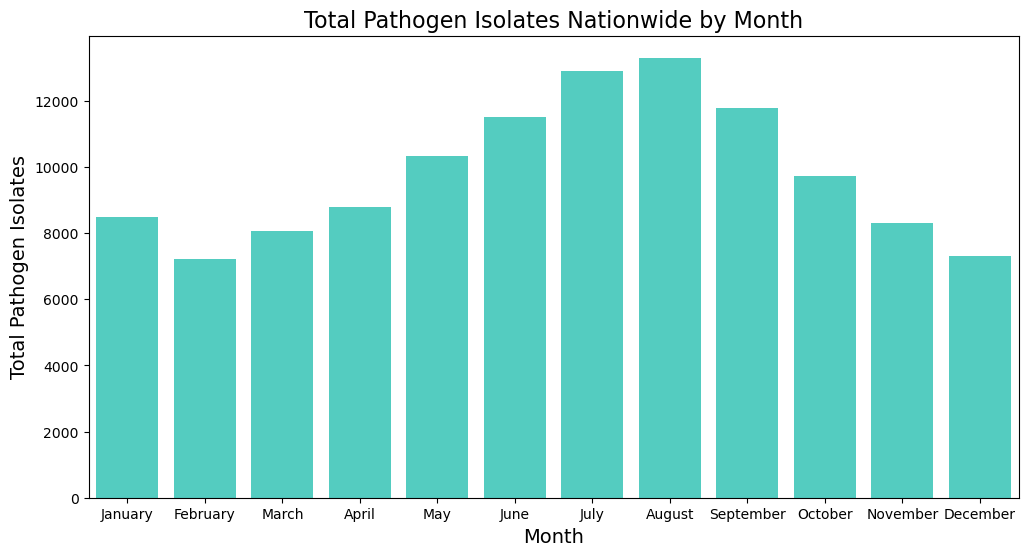

In [23]:
# visualizing total pathogen isolates nationwide by month
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='month', y='Total', data=counts_per_month, color='turquoise')
plt.title('Total Pathogen Isolates Nationwide by Month', fontsize=16)
plt.xlabel('Month', fontsize = 14)
ax.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
plt.ylabel('Total Pathogen Isolates', fontsize = 14)
plt.show()

### Analyzing the cases per quarter (i.e. 2018 Q1, 2018 Q2, etc.)

In [24]:
merged_df['date'] = pd.to_datetime(merged_df[['year', 'month']].assign(day=1))

# group by quarter and sum num_isolates
quarterly_data = (
    merged_df.groupby(pd.Grouper(key='date', freq='Q'))['num_isolates']
    .sum()
    .reset_index()
)

# rename columns for clarity
quarterly_data.rename(columns={'date': 'quarter', 'num_isolates': 'total_isolates'}, inplace=True)

quarterly_data.head()

,quarter,total_isolates
0,2018-03-31,8268
1,2018-06-30,13954
2,2018-09-30,21647
3,2018-12-31,12663
4,2019-03-31,7955


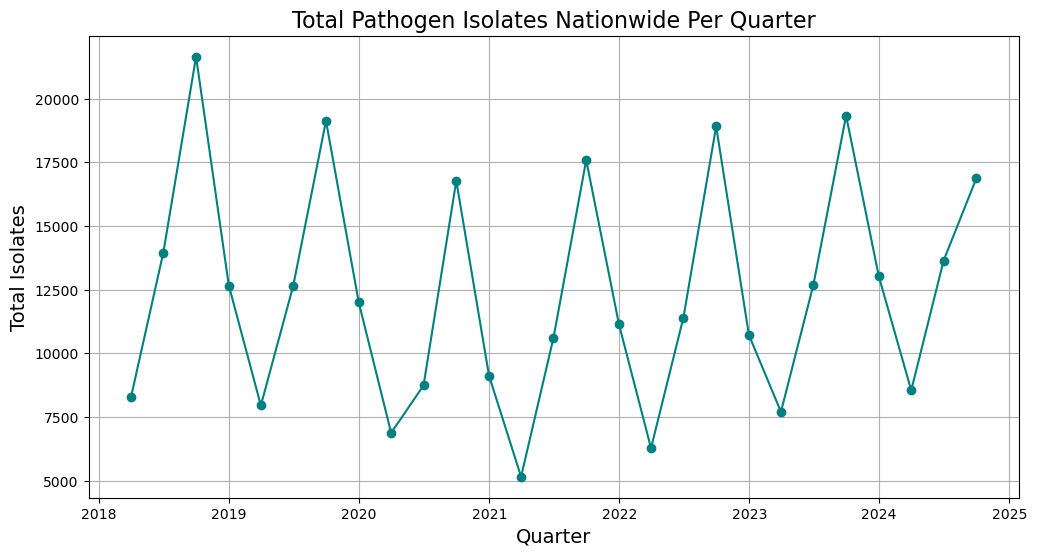

In [25]:
# plot quarterly sum of isolates
plt.figure(figsize=(12, 6))
plt.plot(quarterly_data['quarter'], quarterly_data['total_isolates'], marker='o', linestyle='-', color='teal')
plt.title('Total Pathogen Isolates Nationwide Per Quarter', fontsize = 16)
plt.xlabel('Quarter', fontsize = 14)
plt.ylabel('Total Isolates', fontsize = 14)
plt.grid(True)
plt.show()

### Analyzing the cases per source type

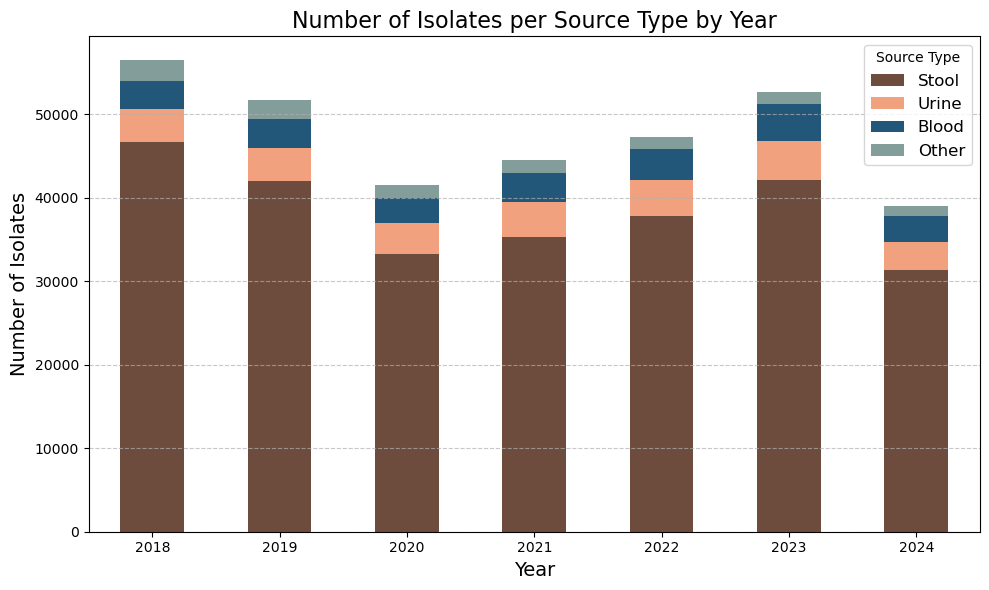

In [26]:
# Step 1: Group and pivot the data as before
cases_per_source = merged_df.groupby(['year', 'source'])['num_isolates'].sum().reset_index()
pivot_table = cases_per_source.pivot(index='year', columns='source', values='num_isolates').fillna(0)

# Step 2: Reorder columns based on the total sum
pivot_table = pivot_table[pivot_table.sum(axis=0).sort_values(ascending=False).index]

# Step 3: Plot the stacked bar plot with reordered columns
pivot_table.plot(kind='bar', stacked=True, figsize=(10, 6), rot = 0, color = ['#6D4C3D', '#F1A17E', '#22577A', '#839D9A'])

# Add titles and labels
plt.title('Number of Isolates per Source Type by Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Isolates', fontsize=14)
plt.legend(title='Source Type', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

## Geospatial Analyses

### Analyzing total outbreaks per state for 2018 - 2023

In [27]:
merged_df.head()

,year,month,state,source,pathogen,serotype_species,num_isolates,geometry,date
0,2024,1,AK,Stool,Campylobacter,jejuni,1,"MULTIPOLYGON (((-2778499.467 -1620603.792, -27...",2024-01-01
1,2024,1,AL,Stool,Campylobacter,coli,1,"POLYGON ((1023282.917 -582853.454, 1023269.168...",2024-01-01
2,2024,1,AL,Stool,Campylobacter,jejuni,2,"POLYGON ((1023282.917 -582853.454, 1023269.168...",2024-01-01
3,2024,1,AR,Stool,Campylobacter,jejuni,1,"POLYGON ((461603.731 -366288.124, 461727.959 -...",2024-01-01
4,2024,1,CA,Stool,Campylobacter,jejuni,1,"MULTIPOLYGON (((-1976277.366 663684.581, -1976...",2024-01-01


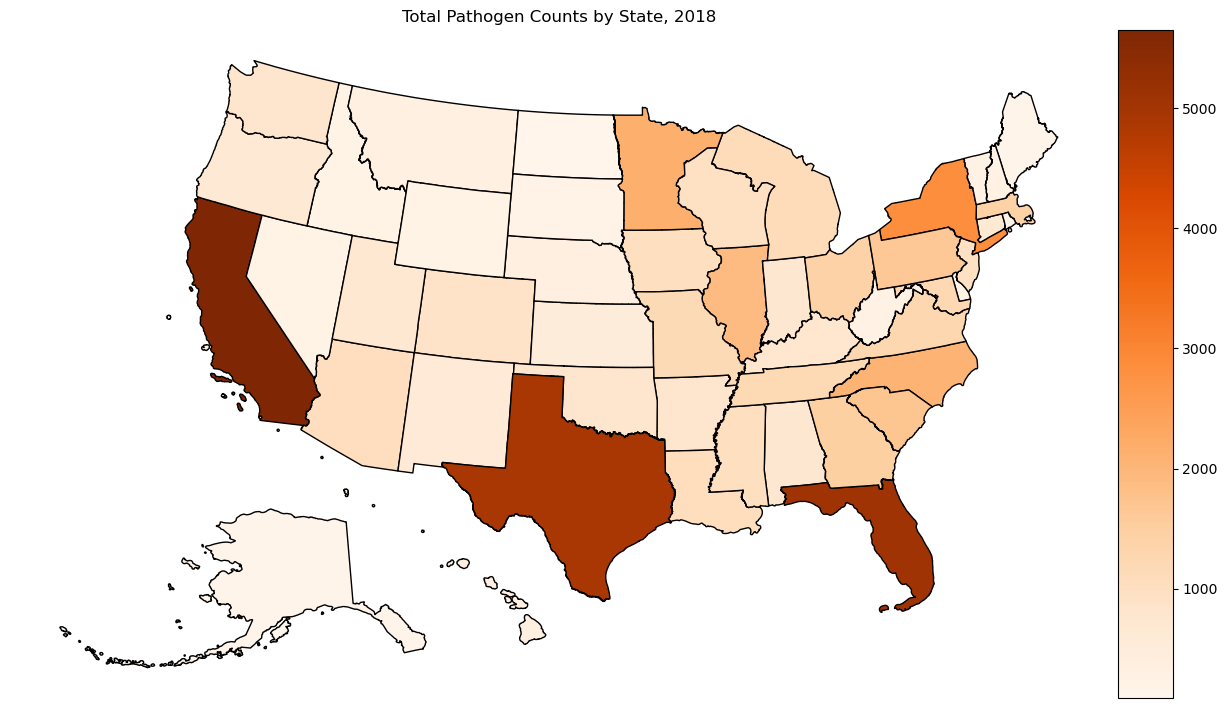

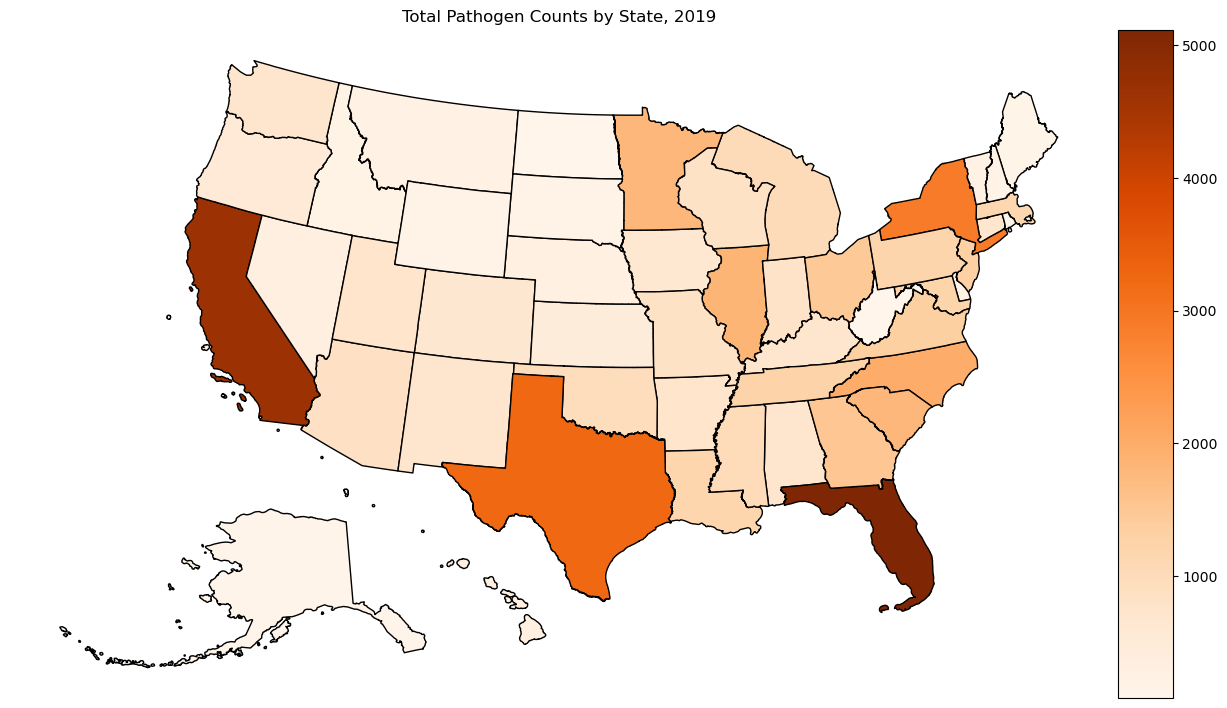

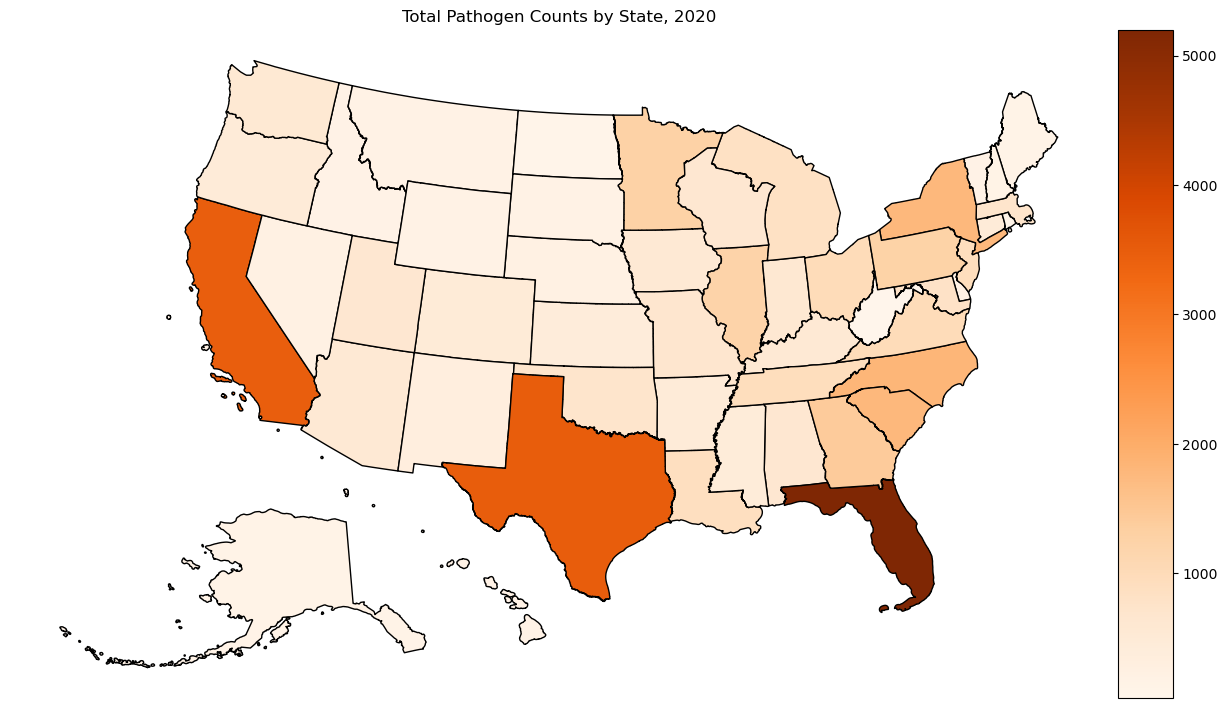

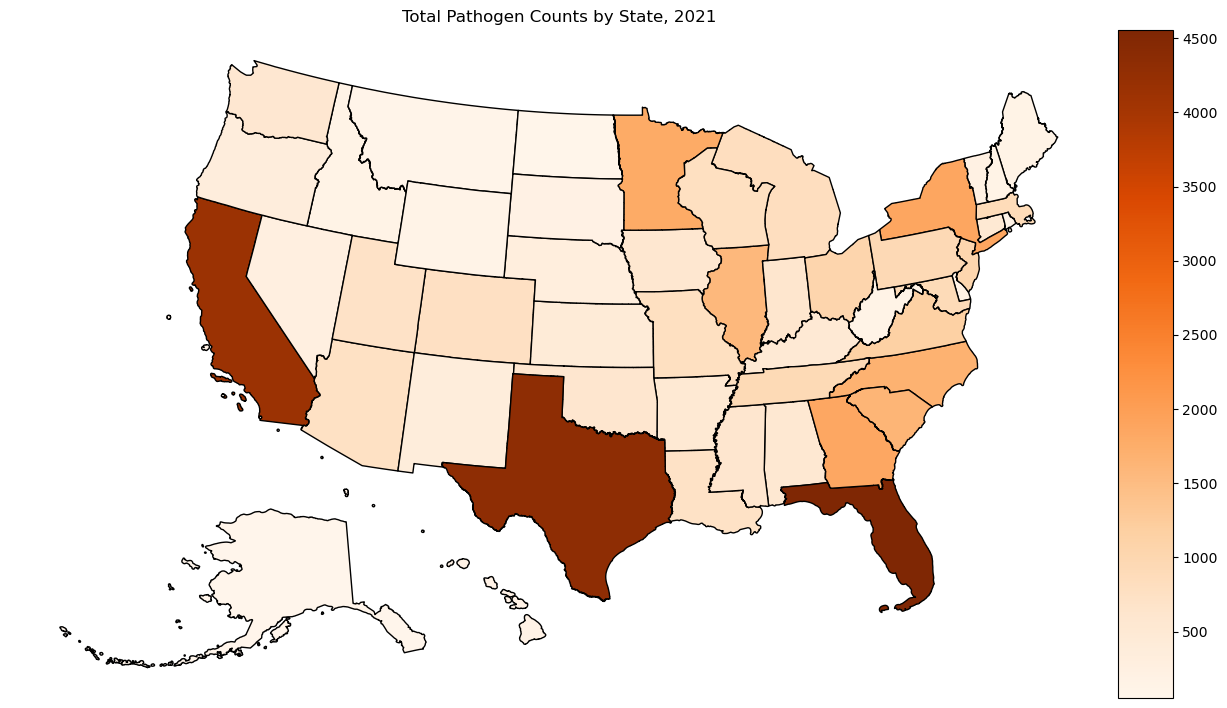

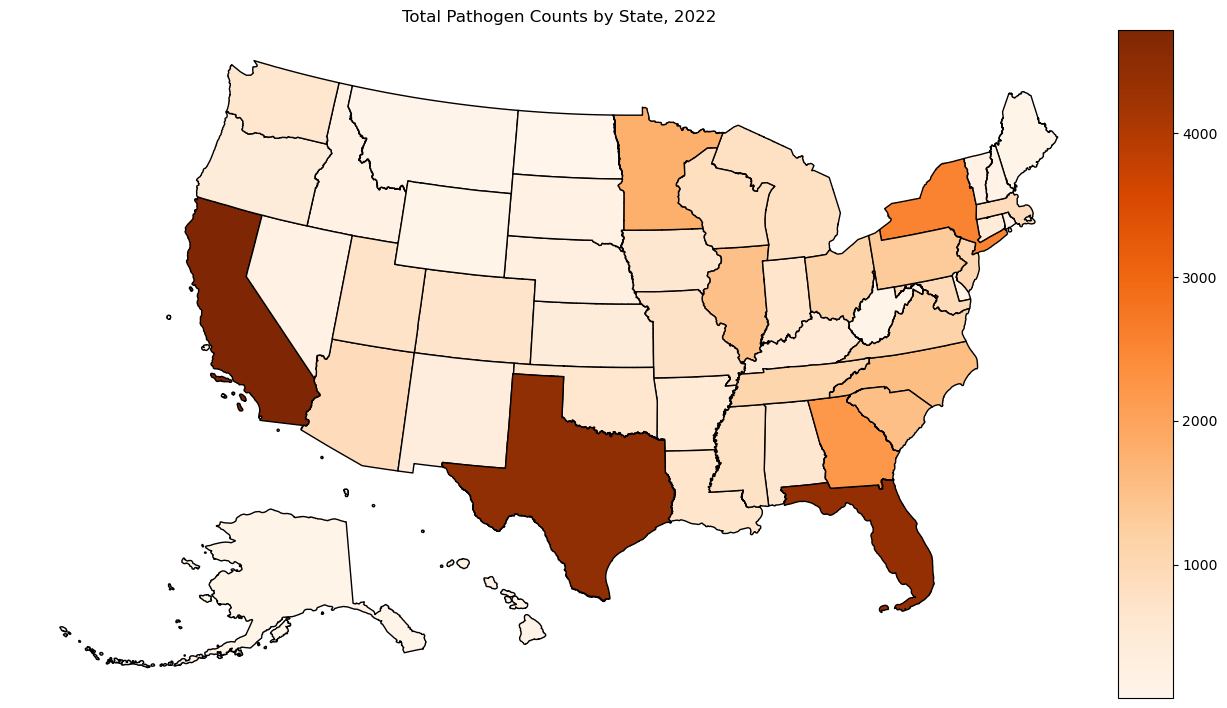

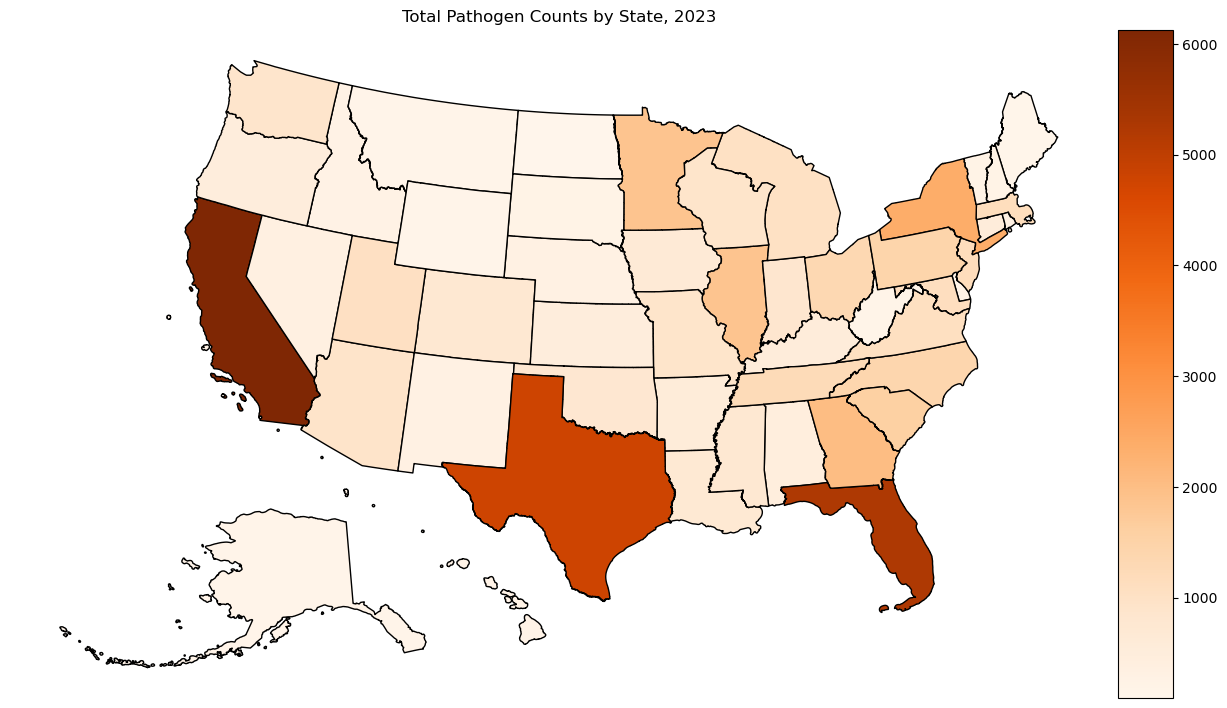

In [28]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

merged_df['num_isolates'] = merged_df['num_isolates'].astype(int)
# sum the isolates by year and state
annual_state_isolates = merged_df.groupby(['year', 'state']).agg({'num_isolates': 'sum', 'geometry': 'first'}).reset_index()

# convert GeoDataFrame
annual_state_isolates = gpd.GeoDataFrame(annual_state_isolates, geometry='geometry')

# maps for each year from 2018 to 2023
years = range(2018, 2024)
for year in years:
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))

    year_data = annual_state_isolates[annual_state_isolates['year'] == year]


    # legend adjustments
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    
    plot = year_data.plot(column='num_isolates', ax=ax, legend=True, cax=cax, cmap = "Oranges", edgecolor = 'black')
    ax.set_title(f'Total Pathogen Counts by State, {year}')
    ax.set_axis_off()
    plt.show()

### Analyzing states with high pathogen counts (CA, TX, FL)

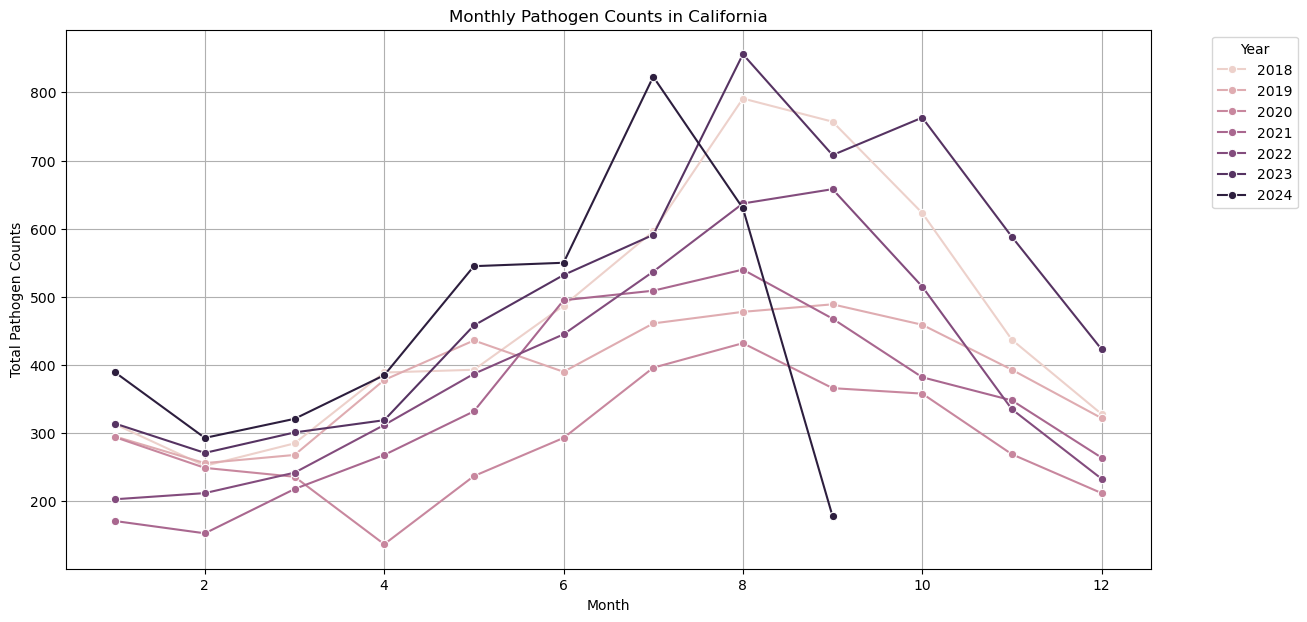

In [29]:
ca_data = merged_df[merged_df['state'] == 'CA']

# for California
ca_monthly = ca_data.groupby(['year', 'month']).agg({'num_isolates': 'sum'}).reset_index()

# Plotting
plt.figure(figsize=(14, 7))
sns.lineplot(x='month', y='num_isolates', hue='year', data=ca_monthly, marker='o')
plt.title('Monthly Pathogen Counts in California')
plt.xlabel('Month')
plt.ylabel('Total Pathogen Counts')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

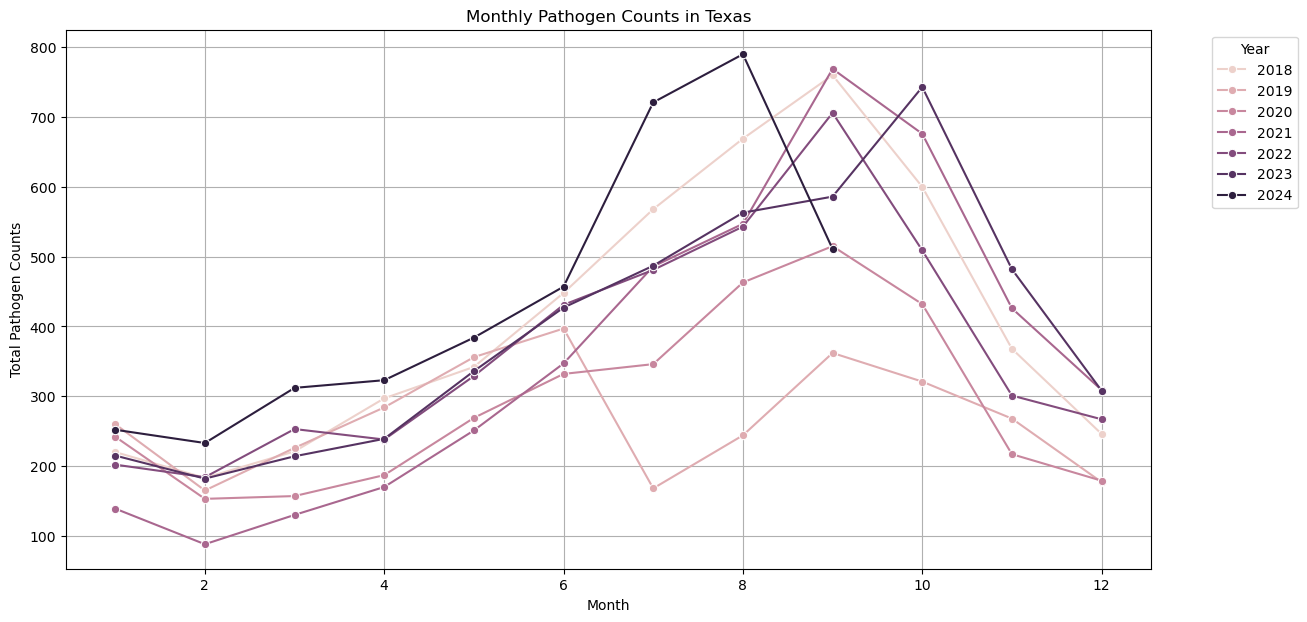

In [30]:
tx_data = merged_df[merged_df['state'] == 'TX']

# for Texas
tx_monthly = tx_data.groupby(['year', 'month']).agg({'num_isolates': 'sum'}).reset_index()

plt.figure(figsize=(14, 7))
sns.lineplot(x='month', y='num_isolates', hue='year', data=tx_monthly, marker='o')
plt.title('Monthly Pathogen Counts in Texas')
plt.xlabel('Month')
plt.ylabel('Total Pathogen Counts')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

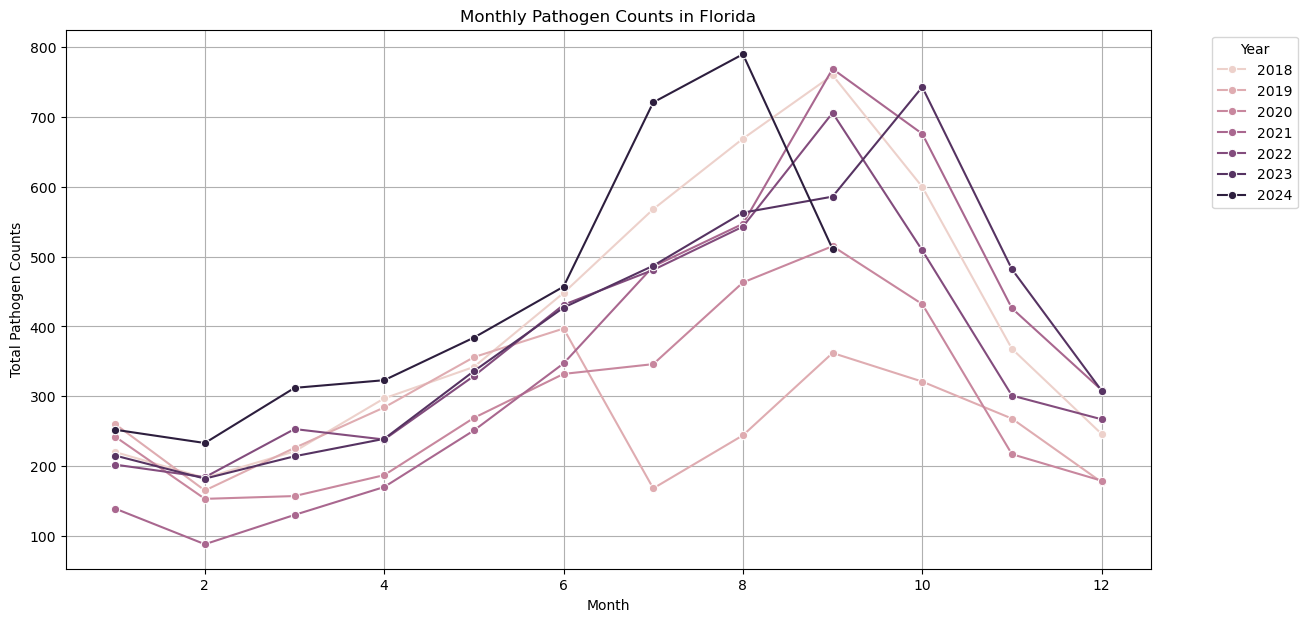

In [31]:
fl_data = merged_df[merged_df['state'] == 'TX']

# for Florida
fl_monthly = fl_data.groupby(['year', 'month']).agg({'num_isolates': 'sum'}).reset_index()

plt.figure(figsize=(14, 7))
sns.lineplot(x='month', y='num_isolates', hue='year', data=fl_monthly, marker='o')
plt.title('Monthly Pathogen Counts in Florida')
plt.xlabel('Month')
plt.ylabel('Total Pathogen Counts')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

In [32]:
states_data = merged_df[merged_df['state'].isin(['CA', 'TX', 'FL'])]

# summing the number of isolates
state_pathogen_counts = states_data.groupby(['state', 'pathogen']).agg({'num_isolates': 'sum'}).unstack(fill_value=0)
state_pathogen_counts.columns = state_pathogen_counts.columns.droplevel(0)

state_pathogen_counts

pathogen,Campylobacter,STEC,Salmonella,Shigella,Vibrio
state,,,,,
CA,582,0,32183,0,92
FL,36,1,32736,0,335
TX,108,41,28784,82,174


### Analyzing total pathogen counts by state per capita (Rishabh)

### Analyzing total pathogen counts by state public health funding per capita

### Analyzing number of foodborne illnesses from salmonella serotypes

The majority of pathogen isolate illnesses come from the pathogen Salmonella. Here, we break down salmonella illnesses by source and serotype.

In [33]:
salmonella_df = pd.read_csv('Salmonella_Burden_Trajectory.csv')
salmonella_df.head()

,Pathogen,table_id,Food_category,Year,Serotype,Burden,Trajectory,Year_range,No_of_illnesses,Burden_sort_order,Trajectory_sort_order,Master_sort_order
0,Salmonella,Beef_Newport_2011-2015,Beef,2020,Newport,High,Increased,2011-2015,176,1,1,1
1,Salmonella,Beef_Newport_2016-2020,Beef,2020,Newport,High,Increased,2016-2020,556,1,1,1
2,Salmonella,Beef_Typhimurium_2011-2015,Beef,2020,Typhimurium,High,Stable,2011-2015,100,1,2,2
3,Salmonella,Beef_Typhimurium_2016-2020,Beef,2020,Typhimurium,High,Stable,2016-2020,54,1,2,2
4,Salmonella,Beef_Dublin_2011-2015,Beef,2020,Dublin,High,Increased,2011-2015,21,1,1,1


This dataset has values for the year ranges 2011-2015, 2016-2020, 2012-2016, and 2017-2021. Due to high amounts of data in the 2011-2015 and 2016-2020 rows, we have chosen to discard the 2012-2016 and 2017-2021 data.

In [34]:
# extract 2011-2015 data
df_2011 = salmonella_df.loc[salmonella_df['Year_range'] == '2011-2015']
# extract 2016-2020 data
df_2016 = salmonella_df.loc[salmonella_df['Year_range'] == '2016-2020']
# merge 2011-2015 and 2016-2020 data 
merged_df = pd.concat([df_2011, df_2016], axis=0)
# create new id column for merged df based on table_id column
merged_df['id'] = merged_df['table_id'].str[:-10]
merged_df = merged_df.drop(['Pathogen', 'Year'], axis=1).sort_values(by='id')
merged_df.head()

,table_id,Food_category,Serotype,Burden,Trajectory,Year_range,No_of_illnesses,Burden_sort_order,Trajectory_sort_order,Master_sort_order,id
13,Beef_Braenderup_2016-2020,Beef,Braenderup,Low,Increased,2016-2020,11,3,1,7,Beef_Braenderup
12,Beef_Braenderup_2011-2015,Beef,Braenderup,Low,Increased,2011-2015,0,3,1,7,Beef_Braenderup
4,Beef_Dublin_2011-2015,Beef,Dublin,High,Increased,2011-2015,21,1,1,1,Beef_Dublin
5,Beef_Dublin_2016-2020,Beef,Dublin,High,Increased,2016-2020,51,1,1,1,Beef_Dublin
16,Beef_Enteritidis_2011-2015,Beef,Enteritidis,Low,Decreased,2011-2015,75,3,3,9,Beef_Enteritidis


In [35]:
# create serotype df using merged df
serotype_df = merged_df[['id', 'No_of_illnesses']]
serotype_df = serotype_df.groupby('id').sum().reset_index()
serotype_df[['source', 'serotype']] = serotype_df['id'].str.split('_', expand=True)
serotype_df = serotype_df.drop('id', axis=1)
serotype_df.head()

,No_of_illnesses,source,serotype
0,11,Beef,Braenderup
1,72,Beef,Dublin
2,81,Beef,Enteritidis
3,32,Beef,Heidelberg
4,4,Beef,Infantis


In [36]:
# create source df using serotype df
source_df = serotype_df.groupby('source').sum().drop(['serotype'], axis=1)
source_df.head()

,No_of_illnesses
source,
Beef,1174
Chicken,3289
Pork,1901
Turkey,1406


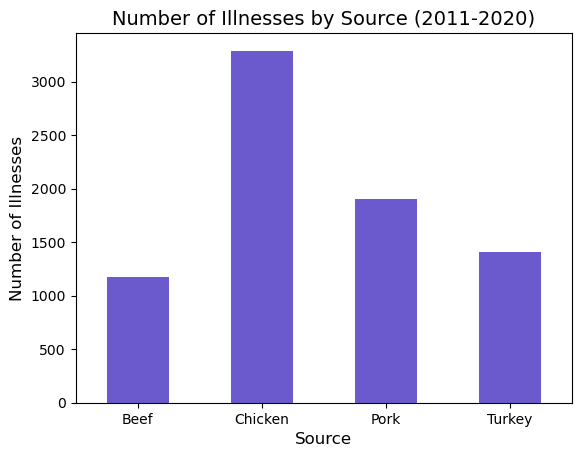

In [37]:
# plot number of illnesses by source
source_df.plot.bar(rot=0, legend=False, color='slateblue')
plt.xlabel('Source', fontsize = 12)
plt.ylabel('Number of Illnesses', fontsize = 12)
plt.title('Number of Illnesses by Source (2011-2020)', fontsize = 14)
plt.show()

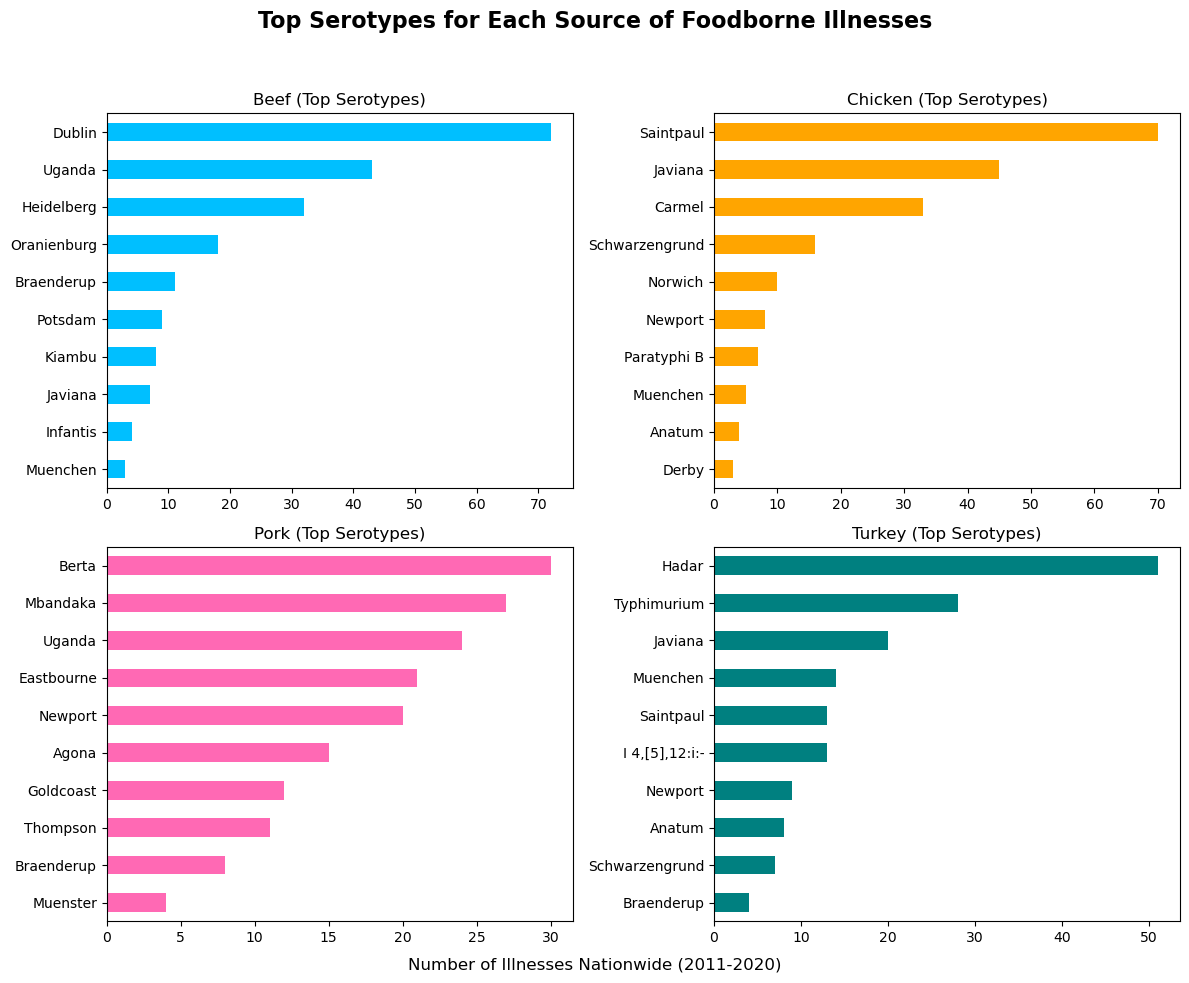

In [39]:
# filter data for each source
sources = serotype_df['source'].unique()
n_sources = len(sources)

# define color map for each source
color_map = {
    'Beef': 'deepskyblue', 
    'Turkey': 'teal',
    'Chicken': 'orange', 
    'Pork': 'hotpink'
}

# Step 2: Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # Flatten the 2x2 array for easier indexing

# Step 3: Plot each source
for i, source in enumerate(sources):
    # Filter data for the current source
    source_df = serotype_df[serotype_df['source'] == source].copy()
    source_df = source_df.sort_values('No_of_illnesses', ascending=True)
    
    # Plot the top 10 serotypes
    ax = axes[i]
    source_df.head(10).plot.barh(x='serotype', y='No_of_illnesses', ax=ax, legend=False, color=color_map[source])
    ax.set_title(f'{source} (Top Serotypes)')
    ax.set_ylabel('')

# Step 4: Turn off unused subplots if there are fewer than 4 sources
for j in range(n_sources, len(axes)):
    fig.delaxes(axes[j])

# Step 5: Add overarching labels and title
fig.suptitle('Top Serotypes for Each Source of Foodborne Illnesses', fontsize=16, weight='bold')  # Add a figure title
fig.text(0.5, 0.02, 'Number of Illnesses Nationwide (2011-2020)', ha='center', fontsize=12)  # X-axis label for the whole figure
# fig.text(0.01, 0.5, 'Serotype', va='center', rotation='vertical', fontsize=12)  # Y-axis label for the whole figure

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to leave space for the title and labels
plt.show()